In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning_improved import *

# Load data
---

In [2]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

* ## Training set

---

In [3]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-01-31 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


---

* ## Validation set

---

In [4]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-02-01 00:00:00':'2024-02-29 23:55:00'] #May val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


---

* ## Test set

---

In [5]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
prices_test = prices.loc['2024-03-01 00:00:00':'2024-03-31 23:55:00']


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


---

# Train agent
---

In [6]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]
# Training parameters
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
                                                                                        zscore_series_train, 
                                                                                        prices_train, 
                                                                                        beta_series_train,
                                                                                        zscore_series_val,
                                                                                        prices_val,
                                                                                        beta_series_val,
                                                                                        initial_capital,
                                                                                        tx_cost,
                                                                                        entry_stop_pairs, 
                                                                                        num_epochs=1000,
                                                                                        batch_size=32,
                                                                                        gamma = 0.99,
                                                                                        lr = 0.001,
                                                                                        epsilon_start = 1,
                                                                                        epsilon_end = 0.01,
                                                                                        epsilon_decay = 0.995,
                                                                                        replay_capacity = 1000,
                                                                                        target_update_freq = 10,
                                                                                        hidden_dim = 64,                                           
                                                                                        )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
Number of cycles: 103
CYCLES:
-------
[timestamp
2024-01-03 06:30:00   -1.123326
2024-01-03 06:35:00   -0.522286
2024-01-03 06:40:00   -0.519712
2024-01-03 06:45:00   -0.561433
2024-01-03 06:50:00   -0.385858
2024-01-03 06:55:00   -0.392379
2024-01-03 07:00:00   -1.010681
2024-01-03 07:05:00   -0.715278
2024-01-03 07:10:00   -0.659440
2024-01-03 07:15:00   -0.751976
2024-01-03 07:20:00   -0.650422
2024-01-03 07:25:00   -0.691895
2024-01-03 07:30:00   -0.500119
2024-01-03 07:35:00   -0.704601
2024-01-03 07:40:00   -0.763439
2024-01-03 07:45:00   -0.941884
2024-01-03 07:50:00   -1.014462
2024-01-03 07:55:00   -1.310253
2024-01-03 08:00:00   -1.129917
2024-01-03 08:05:00   -1.010268
2024-01-03 08:10:00   -0.822616
2024-01-03 08:15:00   -0.975184
2024-01-03 08:20:00   -1.069648
2024-01-03 08:25:00   -0.974079
2024-01-03 08:30:00   -0.883035
2024-01-03 08:35:00   -0.899397
2024-01-03 08:40:00   -0.942740
2024-01-03 08:45:00   -1.216465
2024-01-03 08:50:00   -1.018211
2

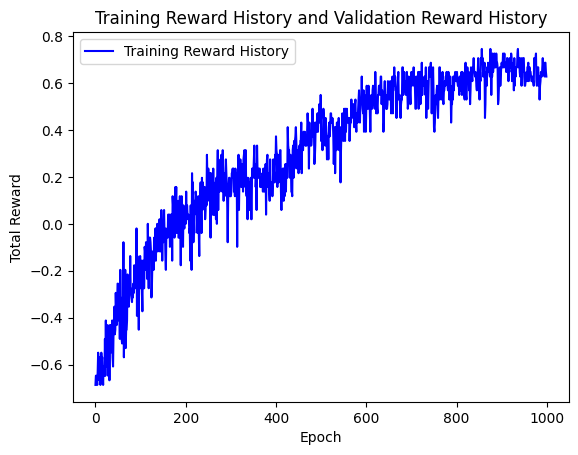

In [7]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
#plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

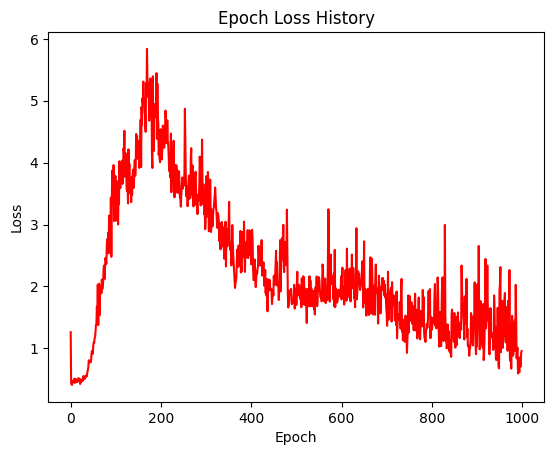

In [8]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Final win rates:  0.8137254901960784
Final loss rates:  0.12745098039215685
Final forced rates:  0.0
Final none rates:  0.058823529411764705


Text(0.5, 0, 'Epoch')

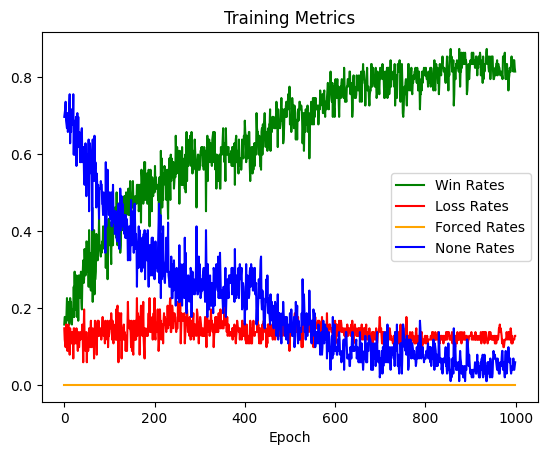

In [9]:
win_rates = training_metrics['win_rates']
loss_rates = training_metrics['loss_rates']
forced_rates = training_metrics['forced_rates']
none_rates = training_metrics['no_trade_rates']

print("Final win rates: ", win_rates[-1])
print("Final loss rates: ", loss_rates[-1])
print("Final forced rates: ", forced_rates[-1])
print("Final none rates: ", none_rates[-1])


plt.plot(win_rates, color = 'green',label = 'Win Rates')
plt.plot(loss_rates, color = 'red', label = 'Loss Rates')
plt.plot(forced_rates, color = 'orange', label = 'Forced Rates')
plt.plot(none_rates, color = 'blue', label = 'None Rates')

plt.legend()
plt.title('Training Metrics')
plt.xlabel('Epoch') 

# Evaluate
---

In [10]:
#Recreate the model and load the saved state_dict
online_net_trained = DQN(input_dim=6, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))



<All keys matched successfully>

In [11]:
tx_cost = 0.0

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_test,
#     prices_test,
#     beta_series_test,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)

test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
    online_net_trained,
    zscore_series_train,
    prices_train,
    beta_series_train,
    initial_capital,
    tx_cost,
    entry_stop_pairs,
)
print(test_metrics)


{'avg_reward': np.float64(0.6470588235294118), 'win_rate': 0.8235294117647058, 'loss_rate': 0.12745098039215685, 'forced_rate': 0.0, 'no_trade_rate': 0.049019607843137254}


In [17]:
actions_profits_list = zip(actions,trade_profits)
actions_profits_df = pd.DataFrame(actions_profits_list, columns=['Actions', 'Trade Profits'])

#Show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

actions_profits_df_zeros = actions_profits_df[actions_profits_df['Trade Profits'] > 0]
actions_profits_df_zeros

,Actions,Trade Profits
0,"(1, 2)",14.827916
3,"(2, 3)",48.740693
5,"(1, 2)",54.905983
7,"(1, 2)",72.536836
8,"(1, 2)",10.163203
11,"(1, 2)",30.201679
12,"(1, 2)",25.098651
13,"(2, 3)",48.673653
14,"(2, 3)",28.451967
16,"(1, 2)",17.815409


percentages:  [65.68627450980392, 22.54901960784314, 5.88235294117647, 2.941176470588235, 1.9607843137254901, 0.9803921568627451]


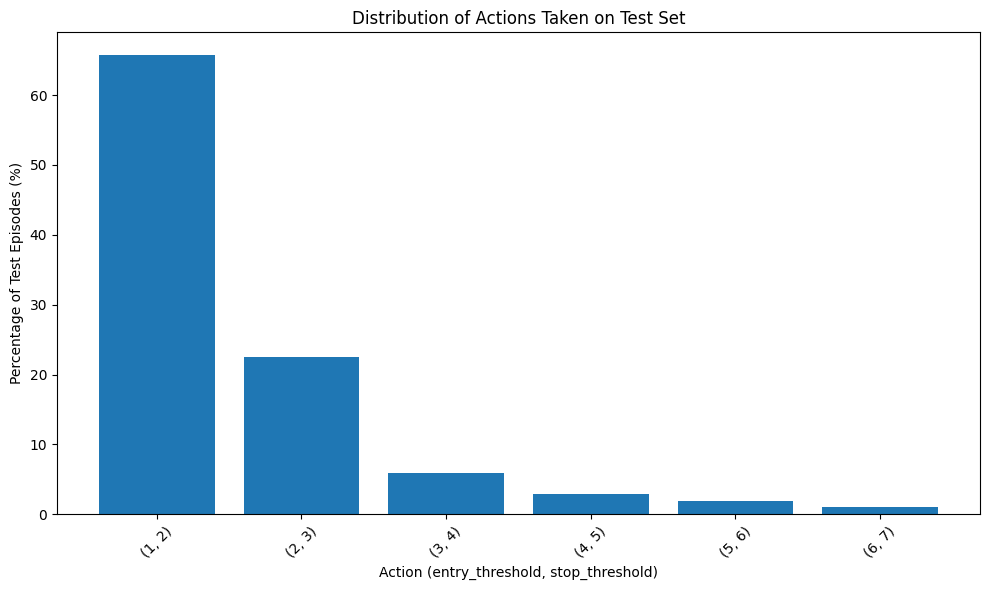

In [13]:
#Count number of each action in the actions list
from collections import Counter

# 1. Count how many times each action appears
counts = Counter(actions)
total = len(actions)

# 2. Compute percentages
actions_sorted = sorted(counts.keys())
percentages = [counts[a] / total * 100 for a in actions_sorted]

print("percentages: ", percentages)


# 4. Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(actions_sorted)), percentages)
plt.xticks(range(len(actions_sorted)), [f"{a}" for a in actions_sorted], rotation=45)
plt.ylabel("Percentage of Test Episodes (%)")
plt.xlabel("Action (entry_threshold, stop_threshold)")
plt.title("Distribution of Actions Taken on Test Set")
plt.tight_layout()
plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  6.,  3.,  6.,
         6.,  6., 18., 12.,  7.,  4.,  5.,  3.,  1.,  3.,  2.,  2.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-171.83732101, -165.03200338, -158.22668575, -151.42136812,
        -144.61605049, -137.81073286, -131.00541523, -124.20009759,
        -117.39477996, -110.58946233, -103.7841447 ,  -96.97882707,
         -90.17350944,  -83.36819181,  -76.56287417,  -69.75755654,
         -62.95223891,  -56.14692128,  -49.34160365,  -42.53628602,
         -35.73096839,  -28.92565075,  -22.12033312,  -15.31501549,
          -8.50969786,   -1.70438023,    5.1009374 ,   11.90625503,
          18.71157267,   25.5168903 ,   32.32220793,   39.12752556,
          45.93284319,   52.73816082,   59.54347845,   66.34879609,
          73.15411372,   79.95943135,   86.76474898,   93.57006661,
         100.37538424,  107.18070187

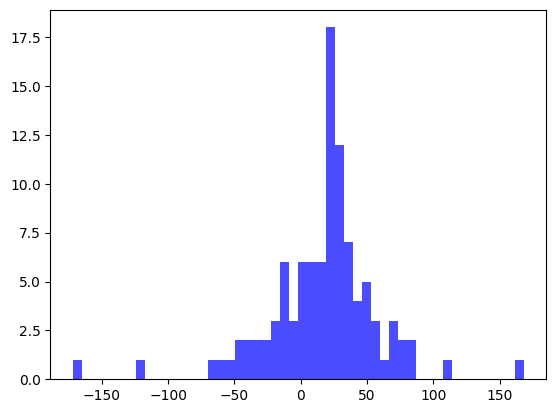

In [14]:
plt.hist(trade_profits, bins=50, color='blue', alpha=0.7)

Final returns:  16.954332036101007 %


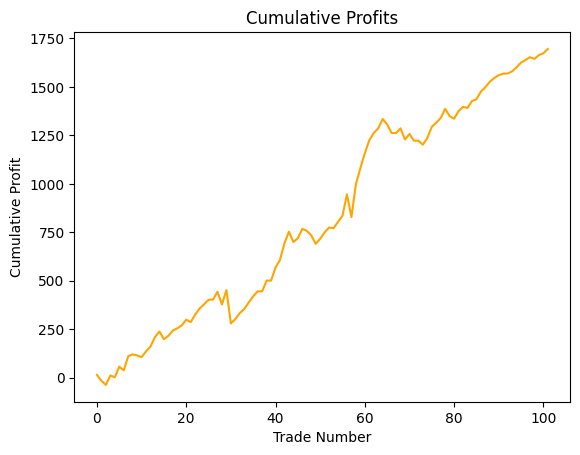

In [15]:
cumulative_profits = np.cumsum(trade_profits)
print("Final returns: ", cumulative_profits[-1]/initial_capital * 100, "%")
plt.plot(cumulative_profits, color='orange')
plt.title('Cumulative Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')
plt.show()